## RQ3: Performance Verification.

1. Merge the tables and Sanity check

In [1]:
import pandas as pd

###############################################################################
# 1. Load raw csv files
###############################################################################

# Edit these paths if needed
bg_path = "../data/RQ2/background_traffic_full.csv"   # background traffic metrics
f1_path = "../data/RQ2/f1res.csv"                # idle and active F1
perf_path = "../data/RQ2/perf.csv"               # per attack performance

bg_df = pd.read_csv(bg_path)
f1_df = pd.read_csv(f1_path)
perf_df = pd.read_csv(perf_path)


###############################################################################
# Normalise device names
###############################################################################

def normalise_device_name(df, col):
    df[col] = df[col].astype(str)
    df["device_clean"] = df[col].str.strip().str.lower()
    return df

bg_df = normalise_device_name(bg_df, "device")
f1_df = normalise_device_name(f1_df, "device")
perf_df = normalise_device_name(perf_df, "device")

###############################################################################
# Convert percent strings to numeric
###############################################################################

def percent_to_float(series):
    return (
        series.astype(str)
        .str.replace("%", "", regex=False)
        .str.strip()
        .replace("", pd.NA)
        .astype(float)
    )

# Convert overall F1
for col in ["f1_idle", "f1_active", "Difference"]:
    f1_df[col] = percent_to_float(f1_df[col])

# Identify attack metrics in perf file
attack_f1_cols = ["icmp_f1", "os_f1", "syn_f1", "scan_f1"]
attack_acc_cols = ["icmp_acc", "os_acc", "syn_acc", "scan_acc"]

# Convert both F1 and Acc
for col in attack_f1_cols + attack_acc_cols:
    perf_df[col] = percent_to_float(perf_df[col])

###############################################################################
# Merge tables
###############################################################################

merged = bg_df.merge(
    f1_df[["device_clean", "f1_idle", "f1_active", "Difference"]],
    on="device_clean",
    how="left"
)

merged = merged.merge(
    perf_df[["device_clean"] + attack_f1_cols + attack_acc_cols],
    on="device_clean",
    how="left"
)

###############################################################################
# Final inspection
###############################################################################

merged.head()


,category,device,pps_idle,pps_active,pps_var_idle,pps_var_active,size_mean_idle,size_mean_active,size_var_idle,size_var_active,...,f1_active,Difference,icmp_f1,os_f1,syn_f1,scan_f1,icmp_acc,os_acc,syn_acc,scan_acc
0,appliance,cosori,0.197136,0.587388,0.313489,1.113073,97.995745,204.644587,2778.366720,33081.272736,...,64.20,10.80,66.74,47.51,49.42,60.65,78.02,70.33,65.93,72.53
1,appliance,honeywell,0.373923,0.094408,0.500000,6.072534,345.333333,210.668161,135507.666667,86785.393892,...,92.61,3.98,92.99,94.46,88.54,92.99,94.44,95.56,92.22,94.44
2,appliance,levoit,0.333162,0.328767,12.998536,11.270024,136.209273,135.962963,27536.860792,29428.662309,...,93.18,3.41,96.99,98.56,85.27,90.19,97.78,98.89,90.00,92.22
3,appliance,swan,0.091900,0.080790,5.741815,1.869944,135.597015,124.197861,41179.981791,18942.062791,...,95.45,-0.57,87.62,82.00,94.18,84.73,91.21,87.78,95.60,90.11
4,appliance,weekett,0.527370,0.601118,1.384587,0.778959,196.138449,187.091603,3123.596810,3648.692992,...,84.09,6.82,85.83,78.33,73.47,90.68,90.11,84.62,83.52,92.31


In [2]:
###############################################################################
# Diagnostics for merged table
###############################################################################

print("Total devices in merged table:", len(merged))

# 1. Check for missing F1 values
missing_f1 = merged[merged["f1_idle"].isna() | merged["f1_active"].isna()]
print("\nDevices missing F1 values:")
display(missing_f1[["device", "device_clean", "f1_idle", "f1_active"]])

# 2. Check for missing per attack metrics
missing_attack = merged[
    merged[["icmp_f1", "os_f1", "syn_f1", "scan_f1"]].isna().any(axis=1)
]
print("\nDevices missing per attack performance:")
display(missing_attack[["device", "icmp_f1", "os_f1", "syn_f1", "scan_f1"]])

# 3. Check for missing background traffic values
bg_cols = [
    "pps_idle","pps_active","pps_var_idle","pps_var_active",
    "size_mean_idle","size_mean_active","size_var_idle","size_var_active"
]
missing_bg = merged[merged[bg_cols].isna().any(axis=1)]
print("\nDevices missing background traffic metrics:")
display(missing_bg[["device"] + bg_cols])

# 4. Check for duplicate device names after cleaning
duplicates = merged["device_clean"].value_counts()
duplicates = duplicates[duplicates > 1]
print("\nDuplicate device entries:")
display(duplicates)

# 5. Quick statistical summary
print("\nQuick summary of key variables:")
display(merged[
    ["f1_idle","f1_active","Difference","pps_idle","pps_active","bts_idle","bts_active"]
].describe())


Total devices in merged table: 34

Devices missing F1 values:


,device,device_clean,f1_idle,f1_active



Devices missing per attack performance:


,device,icmp_f1,os_f1,syn_f1,scan_f1



Devices missing background traffic metrics:


,device,pps_idle,pps_active,pps_var_idle,pps_var_active,size_mean_idle,size_mean_active,size_var_idle,size_var_active



Duplicate device entries:


Series([], Name: count, dtype: int64)


Quick summary of key variables:


,f1_idle,f1_active,Difference,pps_idle,pps_active,bts_idle,bts_active
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,85.799706,80.293235,5.505882,1.694240,156.801236,201.203738,513.829528
std,10.307318,10.930080,8.166396,2.641500,590.459780,165.851022,621.107400
min,64.770000,63.640000,-7.390000,0.026294,0.080790,21.009252,24.798593
25%,78.125000,72.165000,-0.570000,0.249980,0.486610,74.656639,118.533796
50%,90.910000,80.885000,5.965000,0.476606,16.966897,160.158959,483.578101
75%,92.567500,90.342500,9.375000,1.788096,98.253550,256.429059,669.722505
max,96.590000,98.300000,26.700000,11.953214,3445.221097,654.557419,3603.968641


2. Global Correlation Matrix

Performance–Traffic Correlation Map
- which traffic characteristics affect the performance of model

Final traffic metrics used:
['pps_idle', 'pps_active', 'pps_var_idle', 'pps_var_active', 'size_mean_idle', 'size_mean_active', 'size_var_idle', 'size_var_active', 'proto_tls_idle', 'proto_tls_active', 'proto_mdns_idle', 'proto_mdns_active', 'proto_ssdp_idle', 'proto_ssdp_active', 'proto_dhcp_idle', 'proto_dhcp_active', 'proto_other_idle', 'proto_other_active', 'inout_ratio_idle', 'inout_ratio_active', 'num_packets_idle', 'num_packets_active', 'bts_idle', 'bts_active']


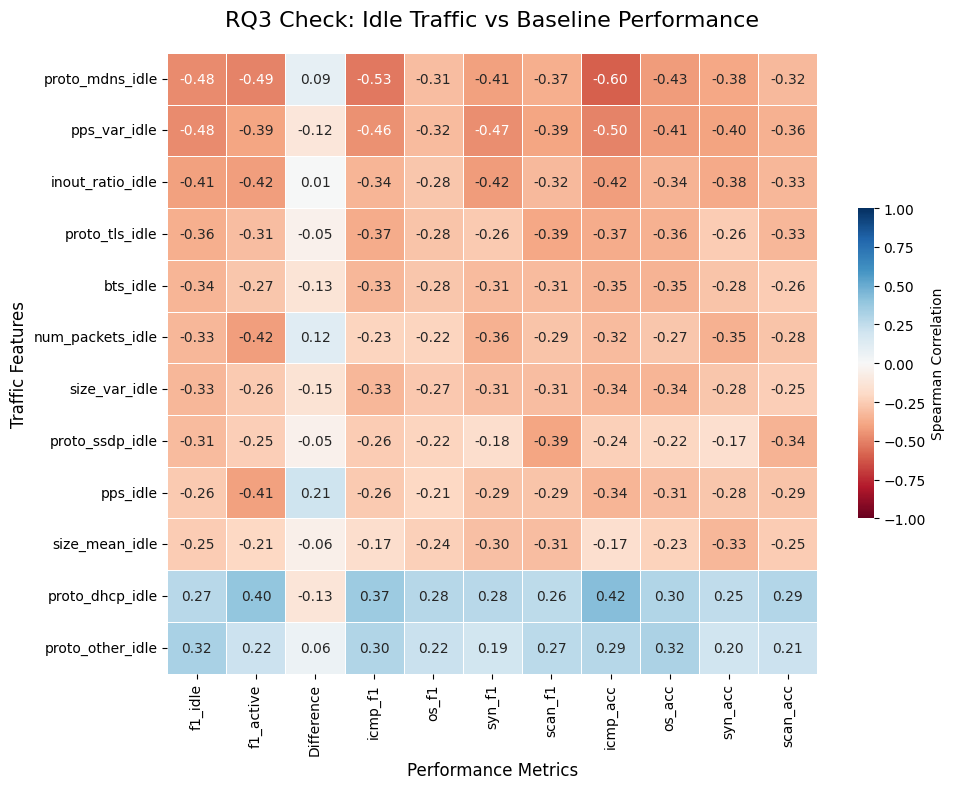

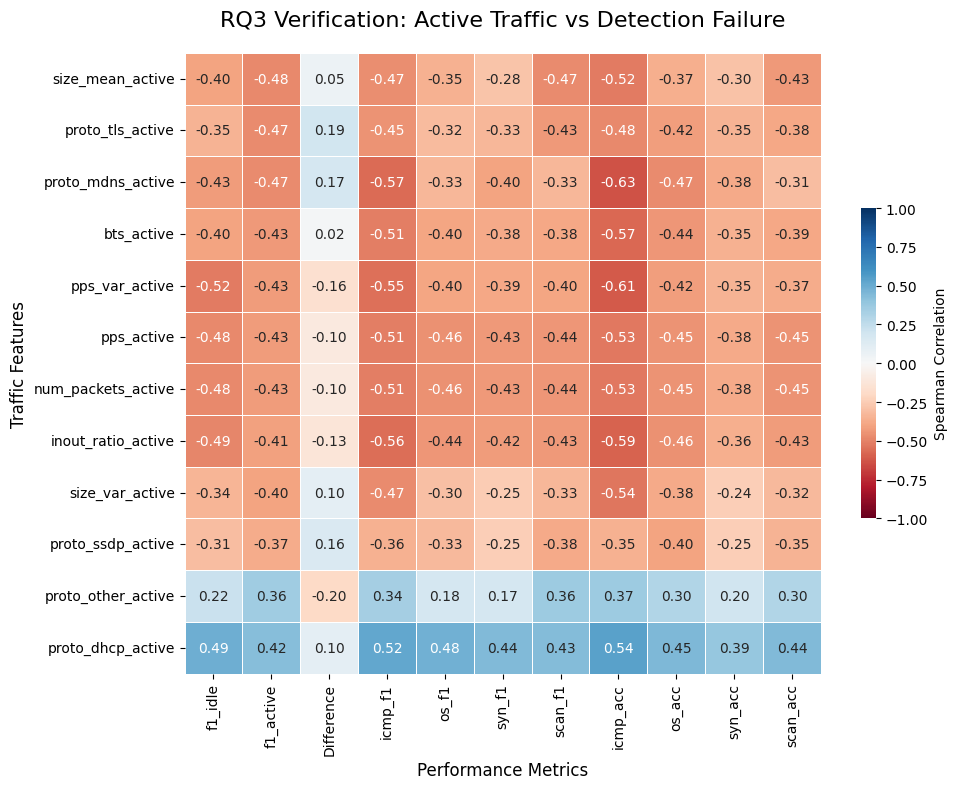

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

###############################################################################
# 1. Define performance metrics
###############################################################################

performance_cols = [
    "f1_idle", "f1_active", "Difference",
    "icmp_f1", "os_f1", "syn_f1", "scan_f1",
    "icmp_acc", "os_acc", "syn_acc", "scan_acc"
]

performance_cols = [c for c in performance_cols if c in merged.columns]


###############################################################################
# 2. Identify all numeric traffic metrics using column prefixes
###############################################################################

traffic_prefixes = [
    "pps_", "pps_var_",
    "size_mean_", "size_var_",
    "proto_", 
    "inout_", 
    "num_packets_",
    "bts_"
]

traffic_cols = [
    c for c in merged.columns
    if any(c.startswith(p) for p in traffic_prefixes)
]

###############################################################################
# Convert traffic columns to numeric (strings -> NaN)
###############################################################################

for c in traffic_cols:
    merged[c] = pd.to_numeric(merged[c], errors="coerce")


###############################################################################
# 3. Remove columns that are all NaN or zero variance
###############################################################################

traffic_df = merged[traffic_cols]

# Remove fully NaN columns
traffic_df = traffic_df.dropna(axis=1, how="all")

# Remove zero variance metrics
nonzero_traffic_cols = [
    c for c in traffic_df.columns
    if traffic_df[c].std() > 1e-6
]

print("Final traffic metrics used:")
print(nonzero_traffic_cols)


###############################################################################
# 4. Split into idle and active traffic metrics
###############################################################################

idle_cols = [c for c in nonzero_traffic_cols if c.endswith("_idle")]
active_cols = [c for c in nonzero_traffic_cols if c.endswith("_active")]


###############################################################################
# 5. Build correlation: Spearman (Rank-Based)
###############################################################################

def compute_corr_matrix(row_cols, col_cols):
    # Use Spearman to handle non-linear/logarithmic relationships
    corr_full = merged[row_cols + col_cols].corr(method='spearman')
    return corr_full.loc[row_cols, col_cols]

corr_idle = compute_corr_matrix(idle_cols, performance_cols)
corr_active = compute_corr_matrix(active_cols, performance_cols)

###############################################################################
# 6. Sort rows by strongest predictor of FAILURE (Negative Correlation)
###############################################################################

def sort_by_impact(corr_matrix, target_col="f1_active"):
    # Sort so the features that destroy accuracy (most negative) are at the top
    if target_col in corr_matrix.columns:
        return corr_matrix.sort_values(by=target_col, ascending=True)
    return corr_matrix

# For Active, we want to see what kills Active F1
corr_active_sorted = sort_by_impact(corr_active, "f1_active")
# For Idle, we might check what correlates with Idle F1
corr_idle_sorted = sort_by_impact(corr_idle, "f1_idle")

###############################################################################
# 7. Improved Heatmap
###############################################################################

def plot_heatmap(corr_matrix, title):
    # Dynamic height based on number of features
    height = max(8, len(corr_matrix) * 0.4) 
    plt.figure(figsize=(10, height))
    
    sns.heatmap(
        corr_matrix,
        cmap="RdBu",  # Red=Positive, Blue=Negative (Standard Scientific)
        vmin=-1, vmax=1, center=0,
        linewidths=0.5,
        linecolor='white',
        annot=True,   # See the numbers!
        fmt=".2f",
        cbar_kws={"shrink": 0.5, "label": "Spearman Correlation"}
    )
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Performance Metrics", fontsize=12)
    plt.ylabel("Traffic Features", fontsize=12)
    plt.tight_layout()
    plt.show()

###############################################################################
# 8. Execution
###############################################################################

plot_heatmap(corr_idle_sorted, "RQ3 Check: Idle Traffic vs Baseline Performance")
plot_heatmap(corr_active_sorted, "RQ3 Verification: Active Traffic vs Detection Failure")